In [1]:
from pathlib import Path
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import sys
import csv

import matplotlib.pyplot as plt

DATA_FOLDER = Path('/data/NER')
DATASET = DATA_FOLDER / 'regex_dataset.tsv'
DATASET_TO_ANNOTATE = DATA_FOLDER / 'annotation_sentences.csv'

In [2]:
%time data = pd.read_csv(str(DATASET), delimiter='\t')

CPU times: user 24 s, sys: 1.21 s, total: 25.2 s
Wall time: 25.2 s


In [3]:
data[data.addr==0].shape

(8234978, 3)

In [4]:
sym = ' "=-.,!?():%'
rus = 'абвгдеёжзиклмнопрстуфхцчшщъыьэюя'
eng = 'abcdefghijklmnopqrstuvwxyz'
dig = '0123456789'

c2id = {c: i+1 for i, c in enumerate(sym+rus+eng+dig)}
id2c = {i: c for c, i in c2id.items()}

capitals = set(c.upper() for c in rus + eng)

CHAR_DIM = len(c2id) + 1

def char2tensor(line, length=256, char_dim=CHAR_DIM):
    tensor = torch.zeros(length, char_dim)
    for k, c in enumerate(line[:length]):
        i = c2id.get(c.lower(), None)
        if i is None:
            continue
        u = int(c in capitals)                
        tensor[k, 0] = u
        tensor[k, i] = 1
    return tensor

def tensor2char(tensor):
    chars_tensor = tensor[:, 1:]
    res = []
    for k in range(len(tensor)):
        u = int(tensor[k, 0])
        max_val, i = chars_tensor[k].max(dim=0)
        
        if max_val[0] == 0:
            break        
        c = id2c[i[0]+1]
#         print(k, c, i[0], u, sep='\t')
        res.append(c.upper() if u else c)
    return ''.join(res)


str_msg = 'Привет там!'
tensor_msg = char2tensor(str_msg)
assert str_msg == tensor2char(tensor_msg)

In [5]:
HIDDEN_DIM = 49

class RNN(nn.Module):
    def __init__(self, input_dim):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        
        self.rnn = nn.LSTM(self.input_dim, HIDDEN_DIM, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(HIDDEN_DIM*2, 1)
        self.logit = nn.Sigmoid()
        
    def forward(self, input):
        out, _ = self.rnn.forward(input)
        out, _ = out.max(1)
        out = self.linear.forward(out)
        out = self.logit(out)
        return out

In [6]:
def cyclic(dataset : list, batch_size):
    data_ = list(dataset)
    while True:
        random.shuffle(data_)
        for i in range(0, len(data_) // batch_size * batch_size, batch_size):
            yield data_[i:i+batch_size]

In [7]:
def pd_cyclic(dataset : pd.DataFrame, batch_size):   
    while True:
        data_ = dataset.sample(frac=1)
        for i in range(0, len(data_) // batch_size * batch_size, batch_size):
            yield data_.iloc[i:i+batch_size]

In [8]:
rnn = RNN(CHAR_DIM)

pos = data[data.addr==1].sample(frac=1)
train_pos_gen = pd_cyclic(pos.iloc[:int(len(pos) * 0.9)], 11)
test_pos = pd_cyclic(pos.iloc[int(len(pos) * 0.9):], int(len(pos) * 0.1))

neg = data[data.addr==0].sample(frac=1)
train_neg_gen = pd_cyclic(neg.iloc[:int(len(neg) * 0.9)], 43)
test_neg = pd_cyclic(neg.iloc[int(len(neg) * 0.9):], int(len(pos) * 0.1) * 4)

train_losses = []
test_losses = []
obs_for_losses = []

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn.parameters())

In [9]:
%%time

print('#seen', 'train', 'test', sep='\t')

train_local_losses = []

obs_seen = 0
for pos, neg in zip(train_pos_gen, train_neg_gen):
    batch = pd.concat([pos, neg])
    batch_size = len(batch)
    
    obs_seen += batch_size
    rnn.zero_grad()
    
    y = Variable(torch.FloatTensor(batch.addr.values))
    x = Variable(torch.stack(batch.text.apply(char2tensor).values))
    
    y_hat = rnn(x)   
    loss = criterion(y_hat, y)
    loss.backward()
    
    optimizer.step()
    
#     print(obs_seen, loss.data[0])
    train_local_losses.append(loss.data[0])
    
    if obs_seen % (1000) < batch_size:
        test_batch = pd.concat([next(test_pos), next(test_neg)])
        test_y = Variable(torch.FloatTensor(test_batch.addr.values))
        test_x = Variable(torch.stack(test_batch.text.apply(char2tensor).values))
        test_y_hat = rnn(test_x)
        test_loss = criterion(test_y_hat, test_y).data[0]
        
        
        test_losses.append(test_loss)
        train_losses.append(np.mean(train_local_losses))
        obs_for_losses.append(obs_seen)
        
        print(obs_seen, np.mean(train_local_losses), test_loss, sep='\t')
        
        train_local_losses = []
        
    if obs_seen > 500_000:
        break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([3165])) that is different to the input size (torch.Size([3165, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


1026	0.6700773897923922	0.6077062487602234
2052	0.5453938183031584	0.5092797875404358
3024	0.5105366375711229	0.5016160607337952
4050	0.504254162311554	0.49867069721221924
5022	0.5026784125301573	0.49718236923217773
6048	0.4999299566996725	0.49433988332748413
7020	0.4963305542866389	0.4850248396396637
8046	0.48746786148924576	0.48033636808395386
9018	0.4689687391122182	0.46285945177078247
10044	0.4386351234034488	0.5110808610916138
11016	0.42654380864567226	0.39078983664512634
12042	0.3938567638397217	0.4778812825679779
13014	0.5028542064958148	0.49041375517845154
14040	0.4510066352392498	0.4051133394241333
15012	0.38329848150412243	0.3669610321521759
16038	0.3550480227721365	0.34441807866096497
17010	0.3274984707434972	0.3221445083618164
18036	0.32578337427816895	0.3225475251674652
19008	0.5250583605633842	0.48000919818878174
20034	0.4930048239858527	0.4793117940425873
21006	0.47493813104099697	0.46770209074020386
22032	0.4638213091774991	0.45858320593833923
23004	0.4597265637583203	0

181008	0.11113763062490357	0.11596731096506119
182034	0.10154015943408012	0.11609460413455963
183006	0.11420856043696404	0.12471800297498703
184032	0.11814253836085922	0.12233517318964005
185004	0.10272775549027655	0.12723347544670105
186030	0.1270606313881121	0.12776213884353638
187002	0.10012905123747057	0.12123164534568787
188028	0.1035166872959388	0.12625214457511902
189000	0.10902094551258618	0.12611006200313568
190026	0.10154838742394197	0.1212650015950203
191052	0.11062600345988023	0.11799723654985428
192024	0.09436622106780608	0.1287325620651245
193050	0.1209149393988283	0.11992601305246353
194022	0.0855484235410889	0.11754870414733887
195048	0.09126095042416923	0.1181984543800354
196020	0.13427621602184242	0.11169968545436859
197046	0.0881224537366315	0.11979405581951141
198018	0.09132546372711658	0.12674443423748016
199044	0.11027664514748674	0.11629602313041687
200016	0.09607396016104354	0.12086556106805801
201042	0.11096461117267609	0.11705493181943893
202014	0.093444901001

357048	0.09397929436282108	0.10392405837774277
358020	0.08531384666760762	0.09299685060977936
359046	0.08639581981850297	0.09959865361452103
360018	0.07385326963331965	0.10279165953397751
361044	0.09348601514571592	0.09956970810890198
362016	0.08664870634675026	0.09128212928771973
363042	0.07040188863481346	0.09940484166145325
364014	0.06548750379847156	0.09951440989971161
365040	0.07441177209349055	0.10189346969127655
366012	0.09615392703562975	0.09494858235120773
367038	0.05381167939815082	0.10649700462818146
368010	0.08407736621383163	0.11587288975715637
369036	0.0675488779027211	0.09410300850868225
370008	0.07212684800227483	0.10147574543952942
371034	0.07009055220374935	0.0963764563202858
372006	0.08087778443263637	0.09358958899974823
373032	0.0834400610704171	0.10967957973480225
374004	0.05749835819005966	0.09599731862545013
375030	0.07368350891690505	0.09904933720827103
376002	0.10285529427023397	0.09892991930246353
377028	0.09201259950273916	0.09209363162517548
378000	0.0681639

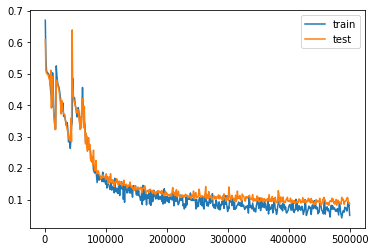

In [10]:
plt.plot(obs_for_losses, train_losses, label='train')
plt.plot(obs_for_losses, test_losses, label='test')
plt.legend()
plt.show()

In [11]:
%%time

with DATASET_TO_ANNOTATE.open('w') as f:
    cw = csv.writer(f)
    cw.writerow(['score', 'sentences', 'regex'])

    bs = 256
    for i in range(0, len(data), bs):
        try:
            d = data[i:i+bs]
            x = Variable(torch.stack(d.text.apply(char2tensor).values))
            y_hat = rnn(x)
            scores = y_hat.data[:, 0].numpy()
            k = np.logical_or(scores > 0.9, d.addr.values)

            for s, (_, row) in zip(scores[k], d[k].iterrows()):
                cw.writerow([s, row.orig.strip(), row.addr])
        except Exception as ex:
            print(ex)
        if i % 10000 < bs:
            print(i)

0
10240
20224
30208
'float' object is not subscriptable
40192
50176
60160
70144
80128
90112
100096
110080
120064
130048
140032
150016
160000
170240
180224
190208
200192
210176
220160
230144
240128
250112
260096
270080
280064
290048
300032
310016
320000
330240
340224
350208
360192
370176
380160
390144
400128
410112
420096
430080
440064
450048
460032
470016
480000
490240
500224
510208
520192
530176
540160
550144
560128
570112
580096
590080
600064
610048
620032
630016
640000
650240
660224
670208
680192
690176
700160
710144
720128
730112
740096
750080
760064
770048
780032
790016
800000
810240
820224
830208
840192
850176
860160
870144
880128
890112
900096
910080
920064
930048
940032
950016
960000
970240
980224
990208
1000192
1010176
1020160
1030144
1040128
1050112
1060096
1070080
1080064
1090048
1100032
1110016
1120000
1130240
1140224
1150208
1160192
1170176
1180160
1190144
1200128
1210112
1220096
1230080
1240064
1250048
1260032
1270016
1280000
1290240
1300224
1310208
1320192
1330176
134016